<center><h1>News Bias Mapping<h1><center>

---

Imports

In [1]:
import json
import pandas as pd
from Metrics import getSentiment, getQuoteBased, getSensationalised, getMudslinging, getSpin, getInformal
from NewsBiasClustering import NewsBiasClusteringFromMetrics

Read in the Data

In [2]:
print('Loading File')
file = open('rust-articles-backup.json', encoding='utf8')
articles = pd.DataFrame.from_dict(json.load(file))
print('File Loaded')

Loading File
File Loaded


Calculate Metric Values

In [3]:
sentiment = []
quoteBased = []
sensationalised = []
mudslinging = []
spin = []
informal = []
for i in range(len(articles)):
    sentiment.append(getSentiment(articles.at[i,'body']))
    quoteBased.append(getQuoteBased(articles.at[i,'body']))
    sensationalised.append(getSensationalised(articles.at[i,'body']))
    mudslinging.append(getMudslinging(articles.at[i,'body']))
    spin.append(getSpin(articles.at[i,'body']))
    informal.append(getInformal(articles.at[i,'body']))
articles['sentiment'] = sentiment
articles['quoteBased'] = quoteBased
articles['sensationalised'] = sensationalised
articles['mudslinging'] = mudslinging
articles['spin'] = spin
articles['informal'] = informal

Cluster Publishers

metro
Counter({0: 2198, 1: 1817})


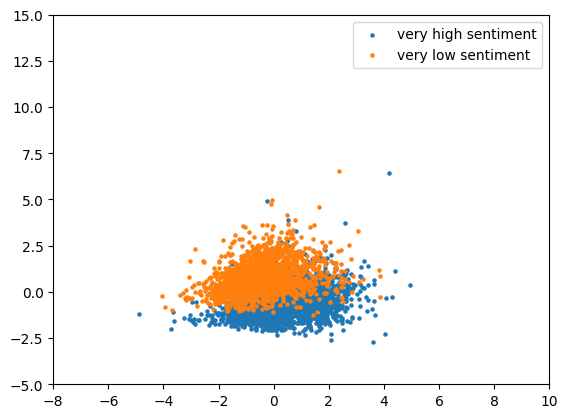

sky
Counter({1: 3081, 0: 2904})


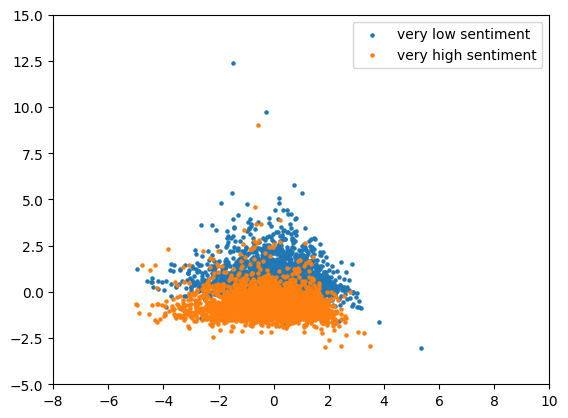

In [4]:
fullArticles = pd.DataFrame()
fullDominantMetrics = pd.DataFrame()
for publisher in list(set(articles['publisher'])):
    print(publisher)
    publisherArticles = articles[articles['publisher'] == publisher].reset_index(drop=True)
    metrics = []
    for i in range(len(publisherArticles)):
        sentiment = publisherArticles.iloc[i]['sentiment']
        quoteBased = publisherArticles.iloc[i]['quoteBased']
        sensationalised = publisherArticles.iloc[i]['sensationalised']
        mudslinging = publisherArticles.iloc[i]['mudslinging']
        spin = publisherArticles.iloc[i]['spin']
        informal = publisherArticles.iloc[i]['informal']
        metrics.append([sentiment, quoteBased, sensationalised, mudslinging, spin, informal])
    labels, dataPCA, dominantMetrics = NewsBiasClusteringFromMetrics(metrics)
    publisherArticles['publisherPC1'] = dataPCA['PC1']
    publisherArticles['PublisherPC2'] = dataPCA['PC2']
    publisherArticles['publisherLabel'] = labels
    fullArticles = pd.concat([fullArticles, publisherArticles])
    dominantMetrics['publisher'] = publisher
    fullDominantMetrics = pd.concat([fullDominantMetrics, dominantMetrics])
fullArticles = fullArticles.reset_index(drop=True)

Cluster All

Counter({0: 5279, 1: 4721})


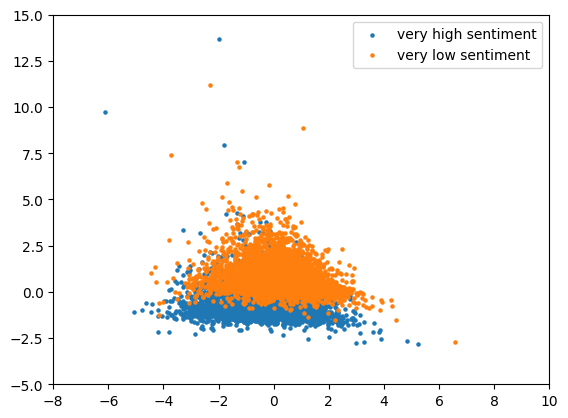

In [5]:
metrics = []
for i in range(len(fullArticles)):
    sentiment = fullArticles.iloc[i]['sentiment']
    quoteBased = fullArticles.iloc[i]['quoteBased']
    sensationalised = fullArticles.iloc[i]['sensationalised']
    mudslinging = fullArticles.iloc[i]['mudslinging']
    spin = fullArticles.iloc[i]['spin']
    informal = fullArticles.iloc[i]['informal']
    metrics.append([sentiment, quoteBased, sensationalised, mudslinging, spin, informal])
labels, dataPCA, dominantMetrics = NewsBiasClusteringFromMetrics(metrics)
fullArticles['fullPC1'] = dataPCA['PC1']
fullArticles['fullPC2'] = dataPCA['PC2']
fullArticles['fullLabel'] = labels
dominantMetrics['publisher'] = 'all'
fullDominantMetrics = pd.concat([fullDominantMetrics,dominantMetrics])
fullDominantMetrics = fullDominantMetrics.reset_index(drop=True)

Format Data

In [6]:
# Format full labels into JSON
data = []
for i in range(len(set(fullArticles.fullLabel))):
    labelPCs = []
    labelData = fullArticles[fullArticles.fullLabel == i].reset_index(drop=True)
    for j in range(len(labelData)):
        labelPCs.append({
            'x': labelData.iloc[j]['fullPC1'],
            'y': labelData.iloc[j]['fullPC2']
        })
    data.append(labelPCs)

# Format Publisher labels into JSON
dataPublishers = []
for publisher in list(set(fullArticles['publisher'].tolist())):
    dataPublisher = []
    grouped = fullArticles[fullArticles['publisher'] == publisher].reset_index(drop=True)
    for i in range(len(set(grouped.publisherLabel))):
        labelPCs = []
        labelData = grouped[grouped.publisherLabel == i].reset_index(drop=True)
        for j in range(len(labelData)):
            labelPCs.append({
                'x': labelData.iloc[j]['publisherPC1'],
                'y': labelData.iloc[j]['PublisherPC2']
            })
        dataPublisher.append(labelPCs)
    dataPublishers.append([publisher,dataPublisher])

# Format publisher countes into JSON
groupedData = []
for publisher in list(set(fullArticles['publisher'].tolist())):
    grouped = fullArticles[fullArticles['publisher'] == publisher][['publisher','fullLabel','body']].groupby(['publisher','fullLabel']).count()
    groupedData.append([publisher,[j[0] for j in grouped.values.tolist()]])

# Format publisher metrics into JSON
groupedMetrics = []
for publisher in list(set(fullArticles['publisher'].tolist())):
    metricData = {'publisher': publisher}
    grouped = fullArticles[fullArticles['publisher'] == publisher].reset_index(drop=True)
    for metric in ['sentiment','quoteBased','sensationalised','mudslinging','spin','informal']:
        metricData[metric] = grouped[metric].tolist()
    groupedMetrics.append(metricData)

Output Data

In [7]:
with open('data/full.json', 'w') as f:
   json.dump(data, f)

with open('data/full-publishers.json', 'w') as f:
   json.dump(dataPublishers, f)

with open('data/full-publisher-counts.json', 'w') as f:
   json.dump(groupedData, f)

with open('data/full-publisher-metrics.json', 'w') as f:
   json.dump(groupedMetrics, f)

fullDominantMetrics.to_json('data/labels.json')

fullArticles.to_json('data/rust-articles-full.json')